In [3]:
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import pyart
import time
import math
import singledop
from copy import deepcopy

from csu_radartools import (csu_misc, csu_kdp)

import gzip
%matplotlib inline

print pyart.__version__

1.7.0.dev+f4b2779


In [5]:
engine = sqlalchemy.create_engine('postgresql://alexandertam@localhost/postgres')
weather = pd.read_sql('SELECT * FROM weather',con = engine)
#weather = weather[weather["IsTornado"] == 1]
weather.drop_duplicates(["Filename","TornadoTime"])
weather = weather[weather["IsTornado"] == 1]
weather.reset_index()
del weather["index"]
weather.head()

,Filename,IsTornado,Episode_ID,Event_ID,TornadoTime,VolumeTime,OriginalTime
19,KHTX20150420_054230_V06.gz,1,93462,569838,05:45:00,05:42:30,00:45:00
25,KBMX20150419_123417_V06.gz,1,95580,574226,12:38:00,12:34:17,07:38:00
82,KHTX20150714_223427_V06.gz,1,96381,593977,22:35:00,22:34:27,17:35:00
186,KHTX20150714_221310_V06.gz,1,96381,593967,22:14:00,22:13:10,17:14:00
195,KHTX20150714_224515_V06.gz,1,96381,593971,22:48:00,22:45:15,17:48:00


In [6]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

In [7]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='ZC'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [8]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='pyart_NWSRef', units1='dBZ', gatefilter1 = None, var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='pyart_NWSRef', units2='dB', gatefilter2 = None, return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True, gatefilter=gatefilter1)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True, gatefilter=gatefilter2)
    display.set_limits(xlim=xlim, ylim=ylim)
    
    if return_flag:
        return fig, ax1, ax2, display

In [9]:
def cleaned_radar_image(filename, radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='pyart_NWSRef', units1='dBZ', gatefilter1 = None,  return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True, gatefilter=gatefilter1,colorbar_flag=True,title_flag=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    display.plot_colorbar = None
    
    #ax1.axis('off')
    
    filename = filename.split('.')[0] + "_"+var1+"_sweep_" + str(sweep)
    print filename
    
    plt.savefig('../images/'+filename,bbox_inches='tight')
    plt.show()
    #plt.close(fig)
    
    if return_flag:
        return fig, ax1, ax2, display

In [23]:
def cleaned_radar_map_image(filename, radar, sweep=0, var='reflectivity', vmin=0, vmax=65,
                    cmap='pyart_NWSRef', units='dBZ', minLat = None, minLong = None, maxLat = None, maxLong = None,
                    tornadoLat = None, tornadoLong = None):
    display = pyart.graph.RadarMapDisplay(radar)

    display.plot_ppi_map(var, sweep, vmin=vmin, vmax=vmax,
                         min_lon=minLong, max_lon=maxLong, min_lat=minLat, max_lat=maxLat,
                         lon_lines=np.arange(-158, -154, .2), projection='lcc',
                         lat_lines=np.arange(69, 72, .1), resolution='h',
                         lat_0=radar.latitude['data'][0],
                         lon_0=radar.longitude['data'][0])

    # plot range rings at 10, 20, 30 and 40km
    display.plot_range_ring(50., line_style='k-')
    display.plot_range_ring(100., line_style='k--')
    display.plot_range_ring(200., line_style='k-')
    display.plot_range_ring(300., line_style='k--')

#     # plots cross hairs
#     display.plot_line_xy(np.array([-40000.0, 40000.0]), np.array([0.0, 0.0]),
#                          line_style='k-')
#     display.plot_line_xy(np.array([0.0, 0.0]), np.array([-20000.0, 200000.0]),
#                          line_style='k-')

    # Indicate the radar location with a point
    try:
        display.plot_point(tornadoLong, tornadoLat)
    except:
        print "Could not plot display tornado point."
        
    filename = filename.split('.')[0] + "_"+var+"_sweep_final" + str(sweep)
    print filename
    
    plt.savefig('../images/'+filename,bbox_inches='tight')

    plt.show()

In [24]:
class BoundingBox(object):
    def __init__(self, *args, **kwargs):
        self.min_lat = None
        self.min_lon = None
        self.max_lat = None
        self.max_lon = None

In [25]:
def get_bounding_box(latitude_in_degrees, longitude_in_degrees, half_side_in_miles):
    assert half_side_in_miles > 0
    assert latitude_in_degrees >= -90.0 and latitude_in_degrees  <= 90.0
    assert longitude_in_degrees >= -180.0 and longitude_in_degrees <= 180.0

    half_side_in_km = half_side_in_miles * 1.609344
    lat = math.radians(latitude_in_degrees)
    lon = math.radians(longitude_in_degrees)

    radius  = 6371
    # Radius of the parallel at given latitude
    parallel_radius = radius*math.cos(lat)

    lat_min = lat - half_side_in_km/radius
    lat_max = lat + half_side_in_km/radius
    lon_min = lon - half_side_in_km/parallel_radius
    lon_max = lon + half_side_in_km/parallel_radius
    rad2deg = math.degrees

    box = BoundingBox()
    box.min_lat = rad2deg(lat_min)
    box.min_lon = rad2deg(lon_min)
    box.max_lat = rad2deg(lat_max)
    box.max_lon = rad2deg(lon_max)

    return (box)

In [26]:
data = weather.copy(deep=True)

Percent Complete:  3.45
Reading KHTX20150420_054230_V06.gz ...
Cleaning ...
Time:  8.236595
Saving ...
KHTX20150420_054230_V06_velocity_sweep_final1


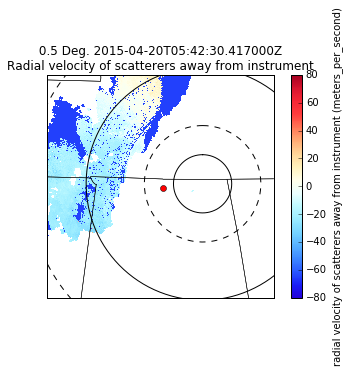

Time:  41.545374
-----------------------------


In [32]:
lenOfData = len(data)-1
for i in range(lenOfData):
#for i in range(392,lenOfWeather):

    print "Percent Complete: ", round((i+1)/float(lenOfData)*100,2)
    print "Reading "+ data.iloc[i,0] + " ..."
    try:
        radar = pyart.io.read_nexrad_archive("../assets/"+ data.iloc[i,0])
    except:
        pass
    print "Cleaning ..."
    start = time.clock()
    
#     dzN = radar.get_field(0,"reflectivity")
#     drN = radar.get_field(0,"differential_reflectivity")
#     dpN = radar.get_field(0,"differential_phase")
#     dvN = radar.get_field(1,"velocity")
    
    
    dzN = extract_unmasked_data(radar, 'reflectivity')
    drN = extract_unmasked_data(radar, 'differential_reflectivity')
    dpN = extract_unmasked_data(radar, 'differential_phase')
    #dvN = extract_unmasked_data(radar, 'velocity')
    
    rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])
    
    kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
    dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=12, gs=250.0, window=5)
    
    #generate insect mask from reflectivity and differential reflectivity
    insect_mask = csu_misc.insect_filter(dzN, drN)
    sdp_mask = csu_misc.differential_phase_filter(sdN, thresh_sdp=13)
    
    #apply mask to respective fields
    bad = -32768
    dz_insect = 1.0 * dzN
    dz_insect[insect_mask] = bad
    dz_sdp = 1.0 * dzN
    dz_sdp[sdp_mask] = bad
    
    #join masks
    new_mask = np.logical_or(insect_mask, sdp_mask)
    
    #copy reflectivity and apply joined mask
    dz_qc = 1.0 * dzN
    dz_qc[new_mask] = bad
    
    #despeckle then add new field to radar object
    mask_ds = csu_misc.despeckle(dz_qc, ngates=15)
    dz_qc[mask_ds] = bad
    radar = add_field_to_radar_object(dz_qc, radar, field_name='DZ_qc', units='dBZ', 
                                  long_name='Reflectivity (Combo Filtered)',
                                  standard_name='Reflectivity (Combo Filtered)', 
                                  dz_field='reflectivity')
    
    reflect_mask = radar.fields["DZ_qc"]["data"].mask[0:720]
    radar.fields["velocity"]["data"][720:1440].mask = reflect_mask
    #radar.fields["velocity"]["data"][720:1440]
    
    
    #dz_mask = getattr(radar.fields['DZ_qc']['data'], 'mask')
    #dv_mask = getattr(radar.fields['velocity']['data'], 'mask')
    #combined_mask = np.logical_or(dz_mask, dv_mask)
    
    #ve = deepcopy(radar.fields['velocity']['data'])
    #radar.add_field_like('velocity', 'DV_qc', ve, replace_existing=True)
    #setattr(radar.fields['DV_qc']['data'], 'mask', combined_mask)

#     dv_qc = 1.0 * dvN
#     dv_qc[new_mask] = 
#     mask_ds = csu_misc.despeckle(dv_qc, ngates=15)
#     dv_qc[mask_ds] = bad


#    radar.get_field(0,"reflectivity")

#     radar = add_field_to_radar_object(dv_qc, radar, field_name='DV_qc', units='m/s', 
#                                    long_name='Velocity (Combo Filtered)',
#                                    standard_name='Velocity (Combo Filtered)', 
#                                    dz_field='velocity')
    end = time.clock()
    print "Time: ", end - start
    print "Saving ..."
    start = time.clock()
#     cleaned_radar_image(event.Filename,radar, sweep=1, var1='velocity', vmin1=-80, vmax1=80, 
#                cmap1='bwr', units1='m/s',
#                xlim=[-300,300], ylim=[-300,300])
    
    sqlStatement = "SELECT latitude,longitude FROM locations WHERE episode_id =" + str(data.iloc[i,2]) + " AND event_id = " + str(data.iloc[i,3])
    
    tornadoLoc = pd.read_sql(sqlStatement,con = engine)
        
    
    box = get_bounding_box(tornadoLoc.latitude[0], tornadoLoc.longitude[0], 120)
    
#     print box.min_lat
#     print box.min_lon
#     print box.max_lat
#     print box.max_lon
#     print "---------"    
#     print tornadoLoc.latitude[0]
#     print tornadoLoc.longitude[0]
    
    cleaned_radar_map_image(data.iloc[i,0], radar, sweep=1, var='velocity', vmin=-80, vmax=80,
                cmap='bwr', units='m/s', minLat = box.min_lat, minLong = box.min_lon, maxLat = box.max_lat, maxLong = box.max_lon,
                tornadoLat = tornadoLoc.latitude[0], tornadoLong = tornadoLoc.longitude[0])

#     print "Debug: "
#     print i+1
#     print len(vel_maxs)
    
#     if(len(vel_maxs) != i + 1):
#         print "HEY SOMETHING WHENT WRONG"

    end = time.clock()
    print "Time: ", end - start
    #print "Progress: ", round(float(i+1)/(lenOfWeather) * 100,2)
    print "-----------------------------"
    
    if(i == 0):
        break

In [33]:
sd_test = singledop.SingleDoppler2D(L=30.0, radar=radar, range_limits=[0, 100],
                                    sweep_number=1, name_vr='velocity',
                                    thin_factor=[4, 12], filter_data=True,
                                    filter_distance=5)

0 total observations (M)


error: (shape(a,0)==shape(b,0)) failed for 2nd argument b

In [ ]:
display = singledop.AnalysisDisplay(sd_test)
display.four_panel_plot(scale=400, legend=20, return_flag=False, thin=6,
                        levels=-30.0+2.0*np.arange(31), name_vr='velocity', name_dz='DZ_qc')